# Parameter Tuning of Sphractal

This notebook contains the analysis of the parameter tuning results for [Sphractal](https://github.com/jon-ting/sphractal), a Python package for the estimation of the fractal dimension of the surfaces of atomistic objects by computing their box-counting dimensions.

## Outline

[Data Set](#data)

[Notebook Setups](#setup)

[Type of Radius](#radType)

[Voxelised Point Cloud SUrface Representation](#voxel)

[Mathematically Exact Surface Representation](#exact)

<a id='data'></a>
## Data Set

We use a set of atomic coordinates of simulated palladium nanoparticles generated for a study on studying the impact of polydispersivity on the properties of palladium nanoparticle electrocatalyst ensembles for parameter tuning here. While the whole data set is currently hosted by [CSIRO Data Access Portal](https://data.csiro.au/collection/csiro:40618), this particularly small set consisting of perfectly shaped nanoparticles (non-energy minimised) was not included in the published data set. They are included in this repository under the `testCases` directory.

The set consists of nanoparticles with 8 different shapes:
- cuboctahedron (CO) -- 826 atoms
- cube (CU) -- 1026 atoms
- decahedron (DH) -- 686 atoms
- icosahedron (IC) -- 923 atoms
- rhombic dodecahedron (RD) -- 670 atoms
- octahedron (OT) -- 1163 atoms
- tetrahedron (TH) -- 875 atoms
- truncated octahedron (TO) -- 807 atoms

<a id='setup'></a>
## Notebook Setups

In [298]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")

Versions of imported libraries:
  matplotlib: 3.7.2
  numpy: 1.24.4
  pandas: 2.0.3
  seaborn: 0.12.2


Below are some general settings for plotting figures:

In [231]:
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, dpi, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
# SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
# plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
# plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
# plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

Some handy general functions:

In [4]:
def readPickle(picklePath):
    with open(picklePath, 'rb') as f: 
        df = pickle.load(f)
    df['shape'] = [name.split('_')[0] for name in df.index]
    df['numAtoms'] = df.apply(lambda f: numAtomsDict[f['shape']], axis=1)
    df['rangeLenVX'] = df.apply(lambda f: f['maxLenVX'] - f['minLenVX'], axis=1)
    df['rangeLenEX'] = df.apply(lambda f: f['maxLenEX'] - f['minLenEX'], axis=1)
    return df

And some handy global variables:

In [5]:
numAtomsDict = {'CO': 826, 'CU': 1026, 'DH': 686, 'IC': 923, 'OT': 670, 'RD': 1163, 'TH': 875, 'TO': 807}

<a id='radType'></a>
## Type of Radius

First we have to select the type of radius to generate the surface, from either `atomic` or `metallic`. 

In [6]:
radDF = readPickle('outputsParamTune/radType/paramTuneRadType.pickle')
cols = ['shape', 'DBoxVX', 'rangeLenVX', 'DBoxEX', 'rangeLenEX', 'radType', 'duration']
radDF = radDF[cols]
radDF.head(3)

,shape,DBoxVX,rangeLenVX,DBoxEX,rangeLenEX,radType,duration
CO_atomic,CO,2.125660,1.20412,2.318761,0.280827,atomic,20.298440
CO_metallic,CO,2.341067,1.20412,2.332303,0.268845,metallic,31.306575
CU_atomic,CU,2.315643,1.20412,2.322652,0.273001,atomic,22.621620


### Duration

Here we look at the impact of the type of radius used on the duration of execution.

In [7]:
atomicRadDF = radDF[radDF['radType'] == 'atomic']
metallicRadDF = radDF[radDF['radType'] == 'metallic']

print(f"Atomic radius average duration: {atomicRadDF['duration'].mean():.3f} s")
print(f"Metallic radius average duration: {metallicRadDF['duration'].mean():.3f} s")

Atomic radius average duration: 21.020 s
Metallic radius average duration: 33.401 s


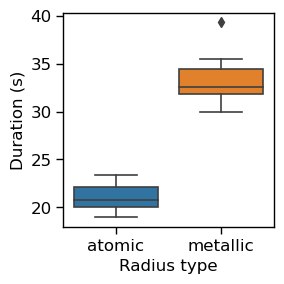

In [105]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=dpi)
g = sns.boxplot(data=radDF, x='radType', y='duration', ax=ax)
plt.xlabel('Radius type')
plt.ylabel('Duration (s)')
plt.tight_layout()
plt.savefig('figures/paramTuneRadDurationBoxPlot.png')

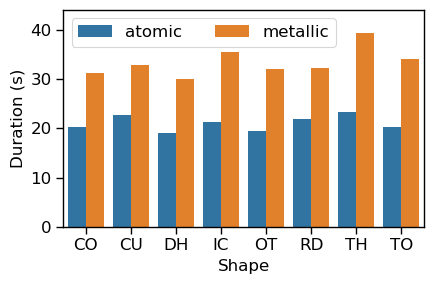

In [29]:
fig, ax = plt.subplots(figsize=(4.5, 3), dpi=dpi)
g = sns.barplot(data=radDF, x='shape', y='duration', hue='radType', ax=ax)
plt.ylim(top=44)
plt.xlabel('Shape')
plt.ylabel('Duration (s)')
plt.legend(title='', loc='upper left', ncol=2)
plt.tight_layout()
plt.savefig('figures/paramTuneRadDurationBarPlot.png')

The computational expenses are significantly higher when metallic radius is used. This is because there are less points that go through the relatively cheaper point removal pipeline, which is triggered when the surface points generated around a sphere lie within the radius of another sphere. This means more points need to be assessed by the algorithm to determine whether they lie on the outer or inner surface, which is relatively more expensive.

### Domain Range

Here we look at the impact of the type of radius used on the domain range from which the final box-counting dimension is computed. 

*Note that the domain range are log-transformed (NEED TO PAY ATTENTION TO UNITS).

In [106]:
print(f"Atomic radius average domain range of voxel representation: {atomicRadDF['rangeLenVX'].mean():.3f}")
print(f"Atomic radius average domain range of surface representation: {atomicRadDF['rangeLenEX'].mean():.3f}")
print(f"Metallic radius average domain range of voxel representation: {metallicRadDF['rangeLenVX'].mean():.3f}")
print(f"Metallic radius average domain range of surface representation: {metallicRadDF['rangeLenEX'].mean():.3f}")

Atomic radius average domain range of voxel representation: 1.204
Atomic radius average domain range of surface representation: 0.273
Metallic radius average domain range of voxel representation: 1.204
Metallic radius average domain range of surface representation: 0.272


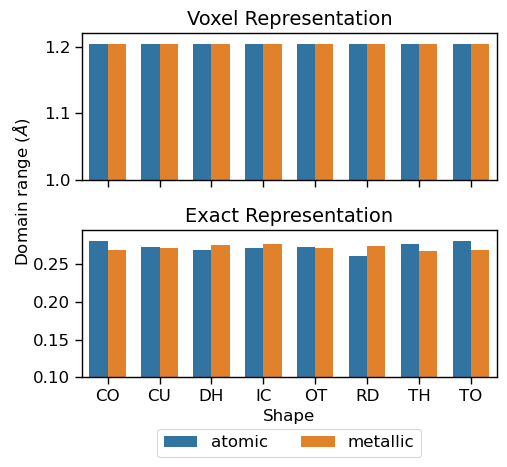

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True, dpi=dpi)
sns.barplot(data=radDF, x='shape', y='rangeLenVX', hue='radType', width=0.7, ax=axes[0])
axes[0].set_ylim(bottom=1.0, top=1.22)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Voxel Representation')
axes[0].legend([], [], frameon=False)
sns.barplot(data=radDF, x='shape', y='rangeLenEX', hue='radType', width=0.7, ax=axes[1])
axes[1].set_ylim(bottom=0.1)
axes[1].set_xlabel('Shape')
axes[1].set_ylabel('')
axes[1].set_title('Exact Representation')
axes[1].legend([], [], frameon=False)
fig.text(-0.01, 0.6, r'Domain range ($\AA$)', va='center', rotation='vertical')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=2)
plt.tight_layout()
plt.savefig('figures/paramTuneRadDomainBarPlot.png')

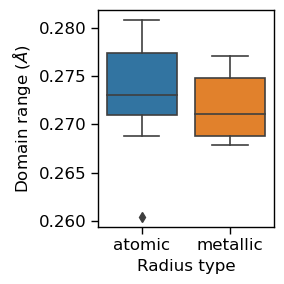

In [109]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=dpi)
g = sns.boxplot(data=radDF, x='radType', y='rangeLenEX', ax=ax)
plt.xlabel('Radius type')
plt.ylabel(r'Domain range ($\AA$)')
plt.tight_layout()
plt.savefig('figures/paramTuneRadDomainBoxPlot.png')

The domain range from the voxel representation was not found to be dependent upon the type of radius used, while a rather small fluctuation was observed for the exact representation.

### Box-Counting Dimension Values

Here we look at the impact of the type of radius used on the values of the box-counting dimensions for the voxel representation (${D_B}_V$) and exact representation (${D_B}_E$) of the surface.

In [30]:
print(f"Atomic radius average box-counting dimension of voxel representation: {atomicRadDF['DBoxVX'].mean():.4f}")
print(f"Atomic radius average box-counting dimension of surface representation: {atomicRadDF['DBoxEX'].mean():.4f}")
print(f"Metallic radius average box-counting dimension of voxel representation: {metallicRadDF['DBoxVX'].mean():.4f}")
print(f"Metallic radius average box-counting dimension of surface representation: {metallicRadDF['DBoxEX'].mean():.4f}")

Atomic radius average box-counting dimension of voxel representation: 2.1748
Atomic radius average box-counting dimension of surface representation: 2.3075
Metallic radius average box-counting dimension of voxel representation: 2.3018
Metallic radius average box-counting dimension of surface representation: 2.3250


In [97]:
# Restructure dataframe for boxplot
radVXDF = radDF.drop(['DBoxEX', 'rangeLenEX'], axis=1)
radVXDF['surfRep'] = 'Voxel'
radVXDF.columns = ['shape', 'DBox', 'rangeLen', 'radType', 'duration', 'surfRep']
radEXDF = radDF.drop(['DBoxVX', 'rangeLenVX'], axis=1)
radEXDF['surfRep'] = 'Exact'
radEXDF.columns = ['shape', 'DBox', 'rangeLen', 'radType', 'duration', 'surfRep']
radVXEXDF = pd.concat([radVXDF, radEXDF], axis=0)

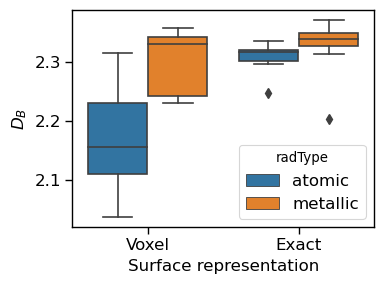

In [100]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=dpi)
g = sns.boxplot(data=radVXEXDF, x='surfRep', y='DBox', hue='radType', ax=ax)
ax.set_xlabel('Surface representation')
ax.set_ylabel(r'${D_B}$')
plt.tight_layout()
plt.savefig('figures/paramTuneRadDBoxBoxPlot.png')

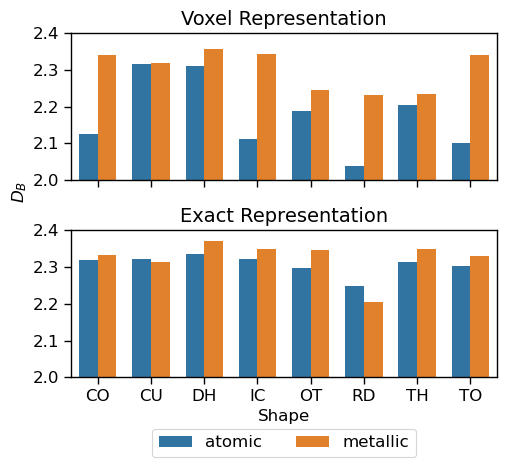

In [102]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True, dpi=dpi)
sns.barplot(data=radDF, x='shape', y='DBoxVX', hue='radType', width=0.7, ax=axes[0])
axes[0].set_ylim(bottom=2.0, top=2.4)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Voxel Representation')
axes[0].legend([], [], frameon=False)
sns.barplot(data=radDF, x='shape', y='DBoxEX', hue='radType', width=0.7, ax=axes[1])
axes[1].set_ylim(bottom=2.0, top=2.4)
axes[1].set_xlabel('Shape')
axes[1].set_ylabel('')
axes[1].set_title('Exact Representation')
axes[1].legend([], [], frameon=False)
fig.text(-0.01, 0.6, r'${D_B}$', va='center', rotation='vertical')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=2)
plt.tight_layout()
plt.savefig('figures/paramTuneRadDBoxBarPlot.png')

The values of $D_B$ are greater on average when metallic radius is used, with the exception being ${D_B}_E$ for `CU` and `RD`, which have lower values with metallic radius. Note that these two shapes are dominated by {100} and {110} facets, respectively. As seen below (left and right correspond to atomic and metallic radii, respectively), this is because the surface areas for nanoparticles with these surface facets are reduced when smaller radii are used due to the presence of more void space in these packings. This leads to lower box counts and thus lower ${D_B}_E$ values.

![CU_atomic_EX](figures/paramTuneCUatomicEX.png)
![CU_metallic_EX](figures/paramTuneCUmetallicEX.png)

![RD_atomic_EX](figures/paramTuneRDatomicEX.png)
![RD_metallic_EX](figures/paramTuneRDmetallicEX.png)

In contrast, the total surface area nanoparticle dominated by {111} facets (such as `OT`) is lower when a larger radius is used, hence an opposite trend is observed for the other nanoparticles.

![OT_atomic_EX](figures/paramTuneOTatomicEX.png)
![OT_metallic_EX](figures/paramTuneOTmetallicEX.png)

### Conclusion

The differences in the results obtained when different types of radius are used are not systematic. We will only proceed with the atomic radius for practical reasons -- cheaper computational cost.

<a id='voxel'></a>
## Voxelised Point Cloud Surface Representation

Next we look at the parameters for the voxelised point cloud representation of a given atomistic surface, particularly number of points to generate around each sphere (`numPoints`) and the minimum number of box count samples (`minSample`).

In [113]:
VXDF = readPickle('outputsParamTune/VX/paramTuneVX.pickle')
cols = ['shape', 'DBoxVX', 'rangeLenVX', 'minSample', 'numPoints', 'duration']
VXDF = VXDF[cols]
VXDF.head(3)

,shape,DBoxVX,rangeLenVX,minSample,numPoints,duration
CO_2500_3_VX,CO,2.562061,0.60206,3,2500,8.499811
CO_2500_4_VX,CO,2.401003,0.90309,4,2500,8.004082
CO_2500_5_VX,CO,2.303134,1.20412,5,2500,7.498640


### Duration

Here we look at the impact of `minSample` and `numPoints` on the duration of execution.

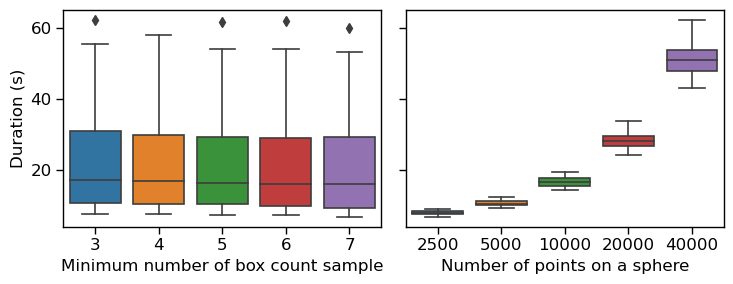

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3), sharey=True, dpi=dpi)
g = sns.boxplot(data=VXDF, x='minSample', y='duration', ax=axes[0])
axes[0].set_xlabel('Minimum number of box count sample')
axes[0].set_ylabel('Duration (s)')
g = sns.boxplot(data=VXDF, x='numPoints', y='duration', ax=axes[1])
axes[1].set_xlabel('Number of points on a sphere')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('figures/paramTuneVXDurationBoxPlot.png')

In [117]:
# fig, ax = plt.subplots(figsize=(6, 4))
# g = sns.barplot(data=VXDF, x='shape', y='duration', hue='minSample', ax=ax)
# plt.xlabel('Shape')
# plt.ylabel('Duration (s)')
# plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5)
# plt.tight_layout()
# plt.savefig('figures/paramTuneVXMinSampleDurationBarPlot.png')

In [18]:
# fig, ax = plt.subplots(figsize=(8, 4))
# g = sns.barplot(data=VXDF, x='shape', y='duration', hue='numPoints', ax=ax)
# plt.xlabel('Shape')
# plt.ylabel('Duration (s)')
# plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5)
# plt.tight_layout()
# plt.savefig('figures/paramTuneVXNumPointsDurationBarPlot.png')

Using more points to approximate each sphere leads to exponential growth in execution duration, while the impact of the minimum number of box count sample is negligible.

### Domain Range

Here we look at the impact of `minSample` and `numPoints` on the domain range.

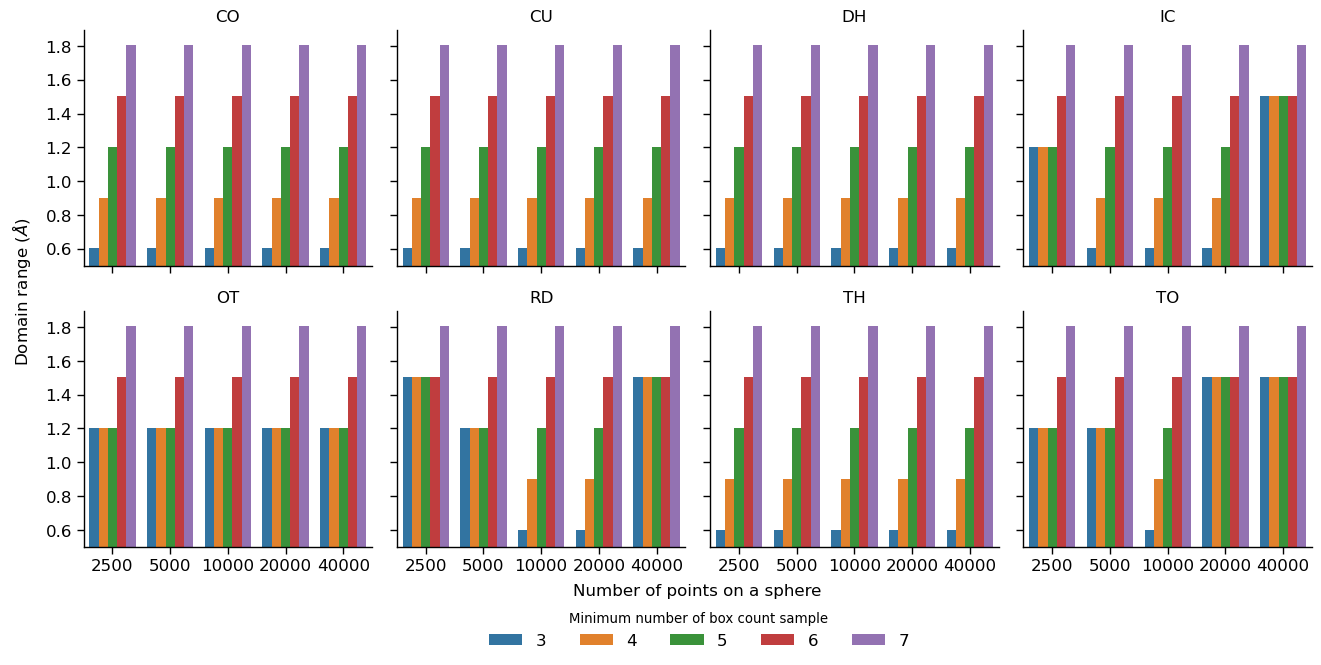

In [156]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g = sns.FacetGrid(VXDF, col='shape', col_wrap=4, sharex=True, sharey=True, height=3, aspect=1.1)
    g.map_dataframe(sns.barplot, x='numPoints', y='rangeLenVX', hue='minSample', palette='tab10')
    g.set(ylim=(0.5, None))
    g.set_axis_labels('', '')
    g.figure.text(-0.01, 0.5, r'Domain range ($\AA$)', va='center', rotation='vertical')
    g.figure.text(0.311, 0.0, 'Number of points on a sphere', va='center')
    g.set_titles(col_template='{col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.add_legend(title='Minimum number of box count sample', loc='lower center', bbox_to_anchor=(0.383, -0.12), ncol=5)
    g.tight_layout()
    g.savefig("figures/paramTuneVXDomainBarPlot.png")

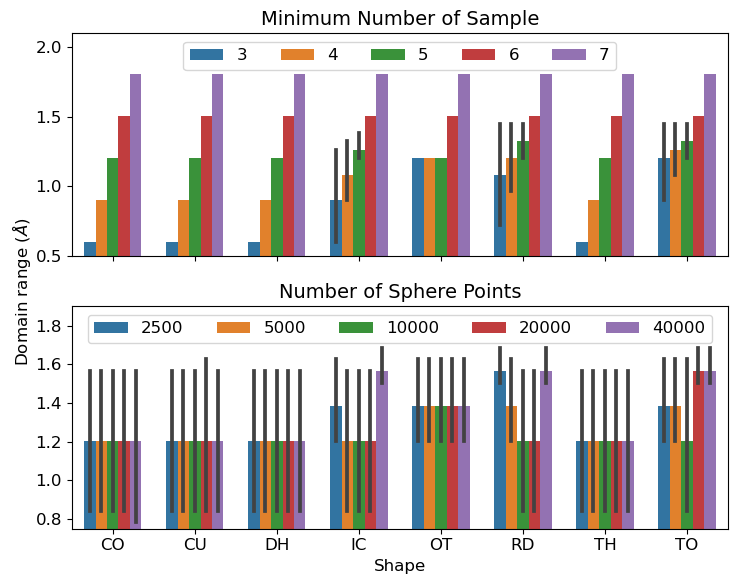

In [245]:
fig, axes = plt.subplots(2, 1, figsize=(7.5, 6), sharex=True, dpi=dpi)
sns.barplot(data=VXDF, x='shape', y='rangeLenVX', hue='minSample', width=0.7, ax=axes[0])
axes[0].set_ylim(bottom=0.5, top=2.1)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Minimum Number of Sample')
axes[0].legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
sns.barplot(data=VXDF, x='shape', y='rangeLenVX', hue='numPoints', width=0.7, ax=axes[1])
axes[1].set_ylim(bottom=0.75, top=1.9)
axes[1].set_xlabel('Shape')
axes[1].set_ylabel('')
axes[1].set_title('Number of Sphere Points')
axes[1].legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
fig.text(-0.01, 0.5, r'Domain range ($\AA$)', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('figures/paramTuneVXDomainBarPlotAgg.png')

The domain range is directly proportional to the minimum number of box count samples. For nanoparticle with certain shapes (`IC`, `RD`, `TO`), generating more points around each sphere sometimes extends the domain range, and returns higher ${D_B}_V$.

### Box-Counting Dimension Values

Here we look at the impact of `minSample` and `numPoints` on the values of ${D_B}_V$.

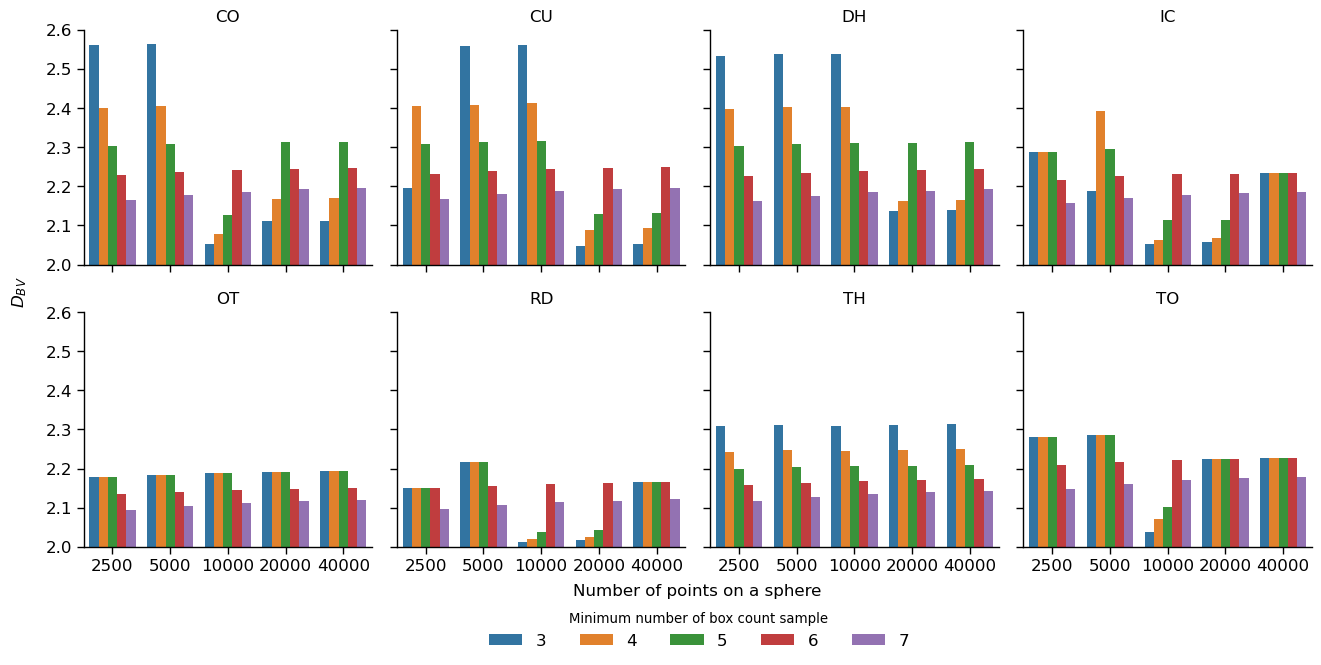

In [152]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g = sns.FacetGrid(VXDF, col='shape', col_wrap=4, sharex=True, sharey=True, height=3, aspect=1.1)
    g.map_dataframe(sns.barplot, x='numPoints', y='DBoxVX', hue='minSample', palette='tab10')
    g.set(ylim=(2.0, 2.6))
    g.set_axis_labels('', '')
    g.figure.text(0.311, 0.0, 'Number of points on a sphere', va='center')
    g.figure.text(-0.01, 0.5, r'${D_B}_V$', va='center', rotation='vertical')
    g.set_titles(col_template='{col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.add_legend(title='Minimum number of box count sample', loc='lower center', bbox_to_anchor=(0.383, -0.12), ncol=5)
    g.tight_layout()
    g.savefig("figures/paramTuneVXDBoxBarPlot.png")

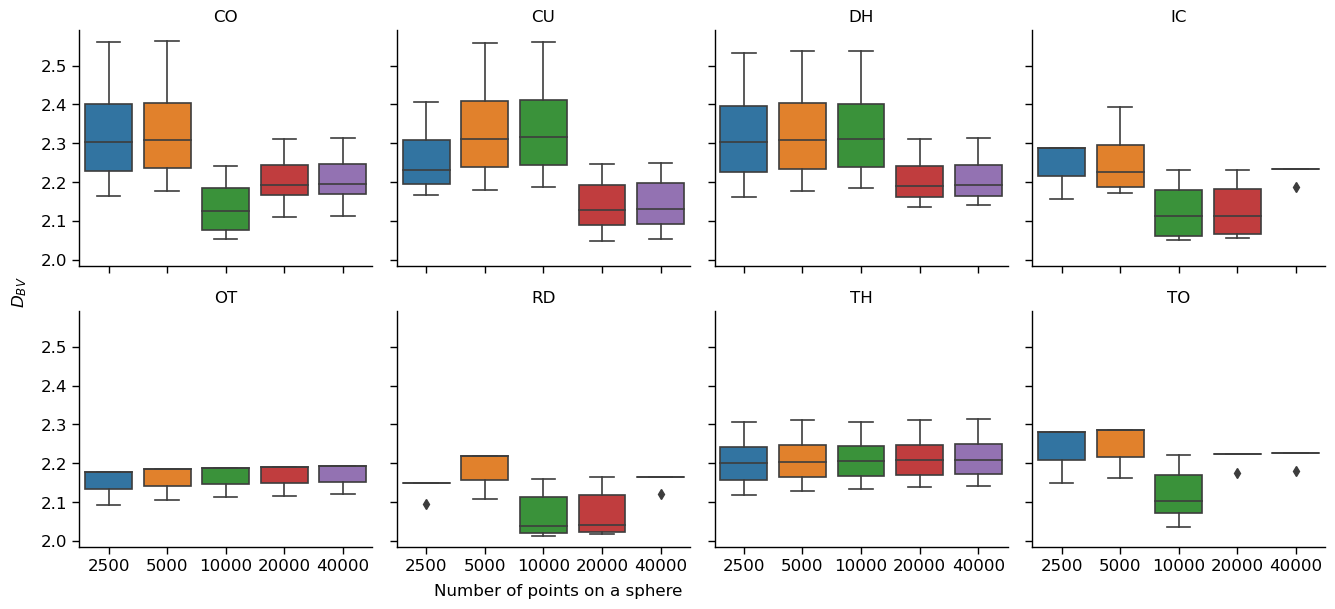

In [161]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g = sns.FacetGrid(VXDF, col='shape', col_wrap=4, sharex=True, sharey=True, height=3, aspect=1.1)
    g.map_dataframe(sns.boxplot, x='numPoints', y='DBoxVX', palette='tab10')
    g.set_axis_labels('', '')
    g.figure.text(-0.01, 0.5, r'${D_B}_V$', va='center', rotation='vertical')
    g.figure.text(0.311, 0.0, 'Number of points on a sphere', va='center')
    g.set_titles(col_template='{col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig("figures/paramTuneVXDBoxNumPointsBoxPlot.png")

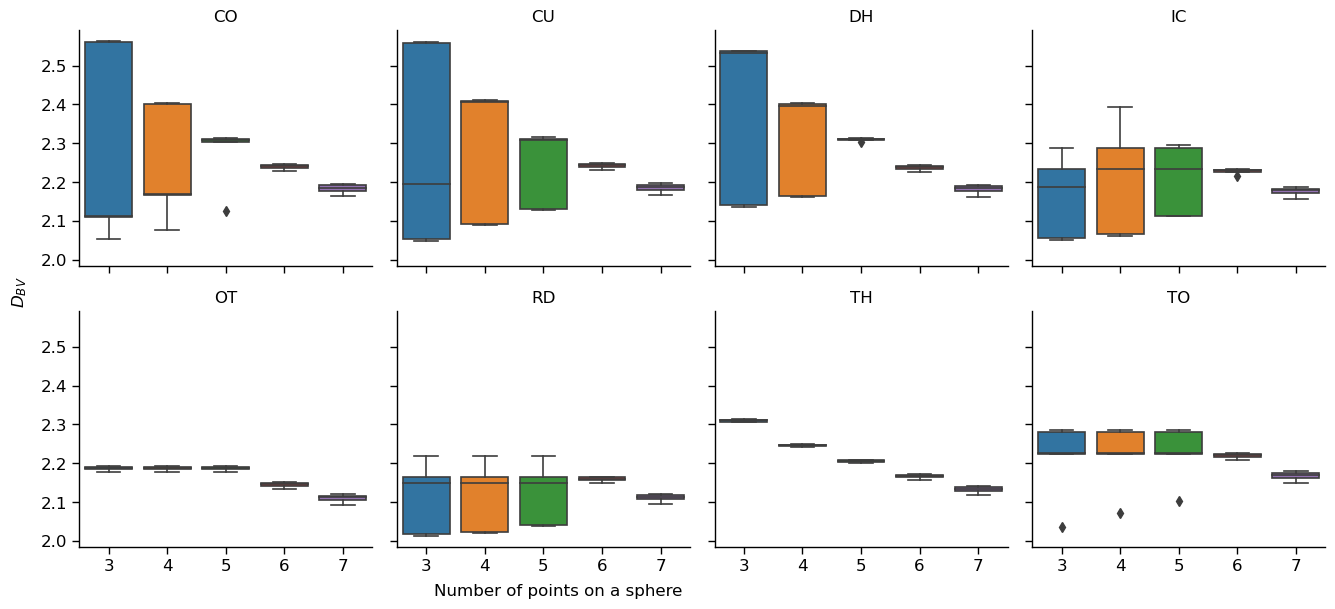

In [165]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g = sns.FacetGrid(VXDF, col='shape', col_wrap=4, sharex=True, sharey=True, height=3, aspect=1.1)
    g.map_dataframe(sns.boxplot, x='minSample', y='DBoxVX', palette='tab10')
    g.set_axis_labels('', '')
    g.figure.text(-0.01, 0.5, r'${D_B}_V$', va='center', rotation='vertical')
    g.figure.text(0.311, 0.0, 'Number of points on a sphere', va='center')
    g.set_titles(col_template='{col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig("figures/paramTuneVXDBoxMinSampleBoxPlot.png")

In [164]:
# fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True, dpi=dpi)
# g = sns.boxplot(data=VXDF, x='minSample', y='DBoxVX', ax=axes[0])
# axes[0].set_xlabel('Minimum number of box count sample')
# axes[0].set_ylabel(r'${D_B}_V$')
# g = sns.boxplot(data=VXDF, x='numPoints', y='DBoxVX', ax=axes[1])
# axes[1].set_xlabel('Number of points on a sphere')
# axes[1].set_ylabel('')
# plt.tight_layout()
# plt.savefig('figures/paramTuneVXDBoxBoxPlot.png')

In [166]:
# fig, axes = plt.subplots(2, 1, figsize=(7.5, 6), sharex=True, dpi=dpi)
# sns.barplot(data=VXDF, x='shape', y='DBoxVX', hue='minSample', width=0.7, ax=axes[0])
# axes[0].set_ylim(bottom=2.0, top=2.55)
# axes[0].set_xlabel('')
# axes[0].set_ylabel('')
# axes[0].set_title('Minimum number of box count sample')
# axes[0].legend(title='', ncol=2)
# sns.barplot(data=VXDF, x='shape', y='DBoxVX', hue='numPoints', width=0.7, ax=axes[1])
# axes[1].set_ylim(bottom=2.0, top=2.5)
# axes[1].set_xlabel('Shape')
# axes[1].set_ylabel('')
# axes[1].set_title('Number of points on a sphere')
# axes[1].legend(title='', ncol=2)
# fig.text(-0.01, 0.5, r'${D_B}_V$', va='center', rotation='vertical')
# plt.tight_layout()
# plt.savefig('figures/paramTuneVXDBoxBarPlotAgg.png')

The number of spherical points have almost no effect on ${D_B}_V$ values of the nanoparticles exclusively covered by {111} facets (`OT` and `TH`). For nanoparticles with these facets, it would be sufficient to use 2500 points.

For other nanoparticles, the variance magnitude in the ${D_B}_V$ values is proportional to the minimum number of box count samples. However, when the minimum number of box count samples is $>=6$, the dependence of the ${D_B}_V$ values on the number of spherical points is removed for nanoparticles of all shapes.

### Conclusion

Considering the computational cost and uncertainty of results, values chosen for `numPoints` and `minSample` are `2500` and `6`, respectively.

Note that this does not tell of the differentiating power between different shapes of the measure, i.e. nanoparticles with different shapes might return similar ${D_B}_V$ values.

<a id='exact'></a>
## Mathematically Exact Surface Representation

### Offset of Box Positions
Next we look at the parameters for the mathematically exact representation of a given atomistic surface, firstly at the `bufferDist` parameter. 

In [168]:
bufferDF = readPickle('outputsParamTune/EX/paramTuneBuffer.pickle')
cols = ['shape', 'DBoxEX', 'rangeLenEX', 'bufferDist', 'duration', ]  # 'lowCIEX', 'upCIEX', 'minLenEX', 'maxLenEX'
bufferDF = bufferDF[cols]
bufferDF.head(3)

,shape,DBoxEX,rangeLenEX,bufferDist,duration
CO_5.0_buffer,CO,2.318761,0.280827,5.0,3.936779
CO_6.0_buffer,CO,2.320481,0.263241,6.0,3.914080
CO_7.0_buffer,CO,2.326735,0.264818,7.0,3.742437


#### Duration

Here we look at the impact of the difference in `bufferDist` on the duration of execution.

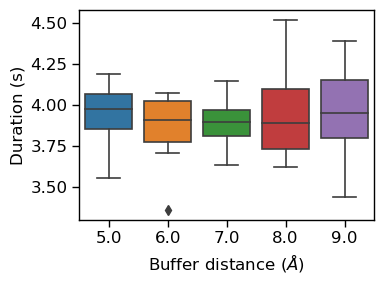

In [169]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=dpi)
g = sns.boxplot(data=bufferDF, x='bufferDist', y='duration', ax=ax)
plt.xlabel(r'Buffer distance ($\AA$)')
plt.ylabel('Duration (s)')
plt.tight_layout()
plt.savefig('figures/paramTuneEXBufferDurationBoxPlot.png')

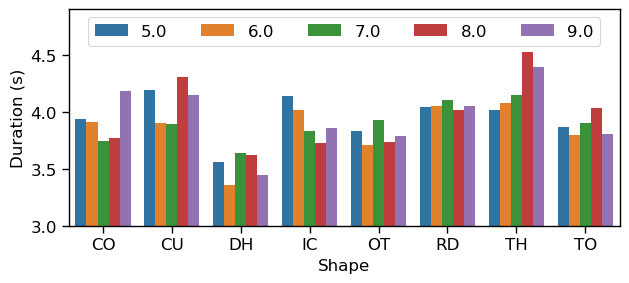

In [170]:
fig, ax = plt.subplots(figsize=(6.5, 3), dpi=dpi)
g = sns.barplot(data=bufferDF, x='shape', y='duration', hue='bufferDist', ax=ax)
plt.ylim(bottom=3, top=4.9)
plt.xlabel('Shape')
plt.ylabel('Duration (s)')
plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
plt.tight_layout()
plt.savefig('figures/paramTuneEXBufferDurationBarPlot.png')

No obvious trend was observed. All fluctations in execution duration are within about 0.5 seconds. The offset does not seem to exert a significant impact on the execution duration.

#### Domain Range

Here we look at the impact of the difference in `bufferDist` on the domain range.

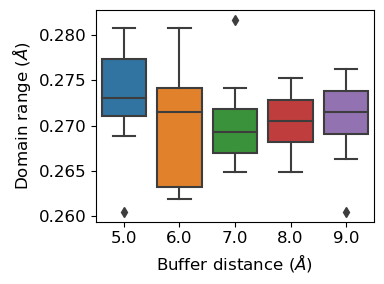

In [279]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=dpi)
g = sns.boxplot(data=bufferDF, x='bufferDist', y='rangeLenEX', ax=ax)
plt.xlabel(r'Buffer distance ($\AA$)')
plt.ylabel(r'Domain range ($\AA$)')
plt.tight_layout()
plt.savefig('figures/paramTuneEXBufferDomainBoxPlot.png')

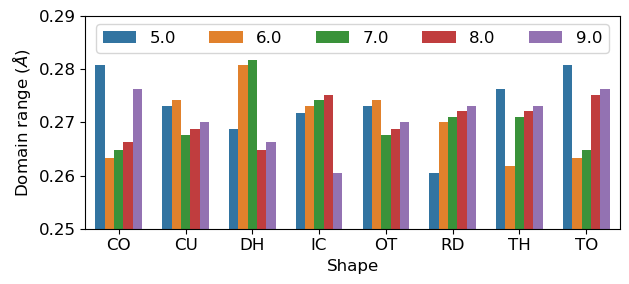

In [278]:
fig, ax = plt.subplots(figsize=(6.5, 3), dpi=dpi)
sns.barplot(data=bufferDF, x='shape', y='rangeLenEX', hue='bufferDist', width=0.7, ax=ax)
plt.ylim(bottom=0.25, top=0.29)
plt.xlabel('Shape')
plt.ylabel(r'Domain range ($\AA$)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
plt.tight_layout()
plt.savefig('figures/paramTuneEXBufferDomainBarPlot.png')

The differences in the resulted domain range when different buffer distances are used are not systematic. The differences are within 0.02 Angstroms, which are relatively small.

#### Box-Counting Dimension Values

Here we look at the impact of the difference in `bufferDist` on the values of ${D_B}_E$.

In [173]:
# fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=dpi)
# g = sns.boxplot(data= bufferDF, x='bufferDist', y='DBoxEX', ax=ax)
# plt.xlabel(r'Buffer distance ($\AA$)')
# plt.ylabel(r'${D_B}_E$')
# plt.tight_layout()
# plt.savefig('figures/paramTuneEXBufferDBoxBoxPlot.png')

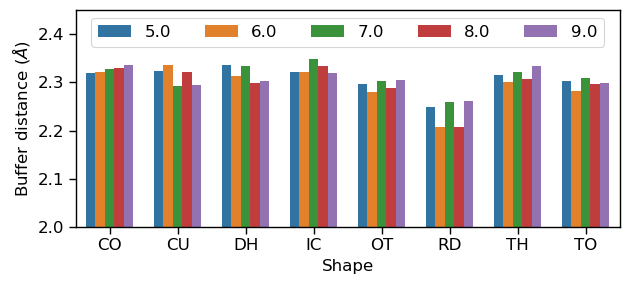

In [174]:
fig, ax = plt.subplots(figsize=(6.5, 3), dpi=dpi)
sns.barplot(data=bufferDF, x='shape', y='DBoxEX', hue='bufferDist', width=0.7, ax=ax)
plt.ylim(bottom=2.0, top=2.45)
plt.xlabel('Shape')
plt.ylabel(r'Buffer distance ($\AA$)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
plt.tight_layout()
plt.savefig('figures/paramTuneEXBufferDBoxBarPlot.png')

Using odd and even number of offset values return slightly different ${D_B}_E$ value. The heaviest impact is observed on the `RD` nanoparticle, with the even number buffer distances returning lower ${D_B}_E$ values. However, the maximum difference is within $\pm0.03$ (about 1% of the ${D_B}_E$ value), which is relatively small.

#### Conclusion

Considering the relatively small impact of the `bufferDist` parameter on the resulted execution duration, domain range, and ${D_B}_E$ values, we will proceed with the default 5.0 Angstroms.

### Range of box lengths

Next we look at the parameters related to the range and interval of box lengths, namely total number of box count samples (`numBoxLen`), minimum number of box count samples for box-counting dimension calculation (`minSample`), multiplier to spherical radius to get minimum box length (`minLenMult`), and multiplier to spherical radius to get maximum box length (`maxLenMult)`.

In [184]:
EXDF = readPickle('outputsParamTune/EX/paramTuneEX.pickle')
cols = ['shape', 'DBoxEX', 'rangeLenEX', 'minSample', 'numBoxLen', 'minLenMult', 'maxLenMult', 'duration']  # 'lowCIEX', 'upCIEX', 'minLenEX', 'maxLenEX'
EXDF = EXDF[cols]
EXDF.head(3)

,shape,DBoxEX,rangeLenEX,minSample,numBoxLen,minLenMult,maxLenMult,duration
CO_0.05_1_10_3_EX,CO,2.310380,0.301030,3,10,0.05,1,49.659136
CO_0.05_1_10_5_EX,CO,2.202646,0.592076,5,10,0.05,1,48.502381
CO_0.05_1_15_5_EX,CO,2.281610,0.381853,5,15,0.05,1,75.209924


#### Duration

We first look at the impact of the difference in box length ranges and intervals on the duration of execution.

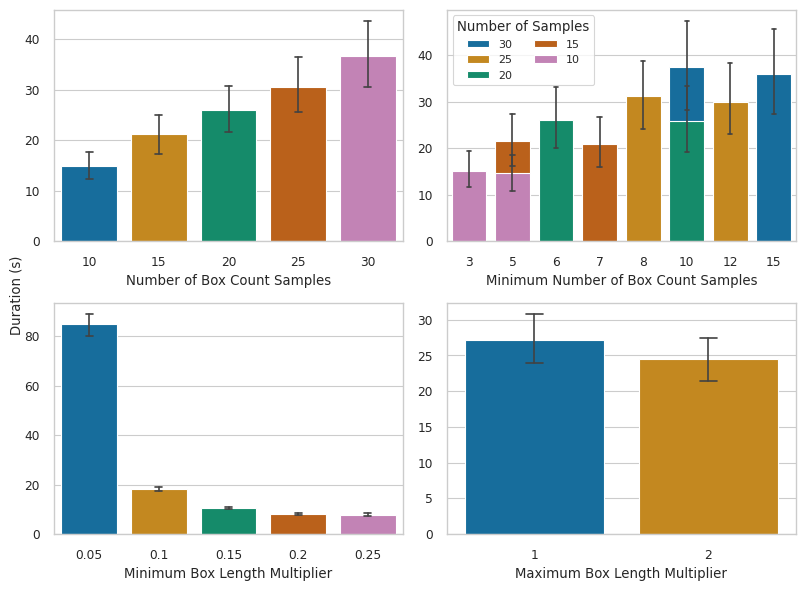

In [233]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=dpi)
g = sns.barplot(data=EXDF, x='numBoxLen', y='duration', errwidth=1.2, capsize=0.1, ax=axes[0, 0])
axes[0, 0].set_xlabel('Number of Box Count Samples')
axes[0, 0].set_ylabel('')
g = sns.barplot(data=EXDF, x='minSample', y='duration', hue='numBoxLen', hue_order=[30, 25, 20, 15, 10], dodge=False, errwidth=1.2, capsize=0.1, ax=axes[0, 1])
axes[0, 1].set_xlabel('Minimum Number of Box Count Samples')
axes[0, 1].set_ylabel('')
axes[0, 1].legend(title='Number of Samples', loc='upper left', ncol=2, fontsize='small')
g = sns.barplot(data=EXDF, x='minLenMult', y='duration', errwidth=1.2, capsize=0.1, ax=axes[1, 0])
axes[1, 0].set_xlabel('Minimum Box Length Multiplier')
axes[1, 0].set_ylabel('')
g = sns.barplot(data=EXDF, x='maxLenMult', y='duration', errwidth=1.2, capsize=0.1, ax=axes[1, 1])
axes[1, 1].set_xlabel('Maximum Box Length Multiplier')
axes[1, 1].set_ylabel('')
fig.text(0.0, 0.5, 'Duration (s)', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('figures/paramTuneEXBoxLenDurationBarPlot.png')

The execution time is directly proportional with the total number of box count samples. 

The graph of minimum number of box count sample should be interpreted by taking the total number of box count samples into account, as the proportion of minimum box count sample is maintained at around 30% and 50%. For example, when a total of 10 box count samples are used, setting the minimum sample number to 3 (30% retention) results in longer execution duration compared to 5 (50% retention). This is intuitive as a lower minimum means more iterations of box count sample removal are allowed.

Extending the maximum box lengths does not have significant impact on the execution duration, but using smaller boxes significantly increases run time. 

#### Domain Range

Here we look at the impact of the difference in box length ranges and intervals on the domain range.

In [263]:
# Add a column for combinations of box length multipliers
EXDF['lenMult'] = EXDF.apply(lambda f: (f['minLenMult'], f['maxLenMult']), axis=1)
EXDF.sort_values(by=['maxLenMult', 'minLenMult'], inplace=True)
EXDF.head(3)

,shape,DBoxEX,rangeLenEX,minSample,numBoxLen,minLenMult,maxLenMult,duration,lenMult
CO_0.05_1_10_3_EX,CO,2.310380,0.301030,3,10,0.05,1,49.659136,"(0.05, 1)"
CO_0.05_1_10_5_EX,CO,2.202646,0.592076,5,10,0.05,1,48.502381,"(0.05, 1)"
CO_0.05_1_15_5_EX,CO,2.281610,0.381853,5,15,0.05,1,75.209924,"(0.05, 1)"


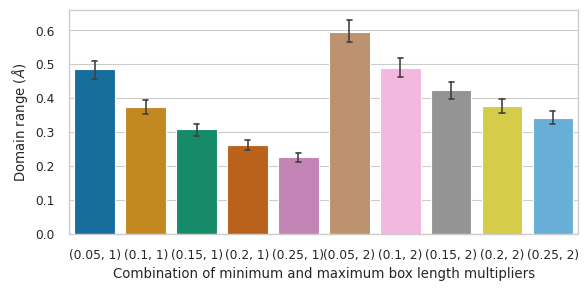

In [272]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=dpi)
sns.barplot(data=EXDF, x='lenMult', y='rangeLenEX', errwidth=1.2, capsize=0.1, ax=ax)
plt.xlabel('Combination of minimum and maximum box length multipliers')
plt.ylabel(r'Domain range ($\AA$)')
plt.tight_layout()
plt.savefig('figures/paramTuneEXBoxLenComboDomainBarPlot.png')

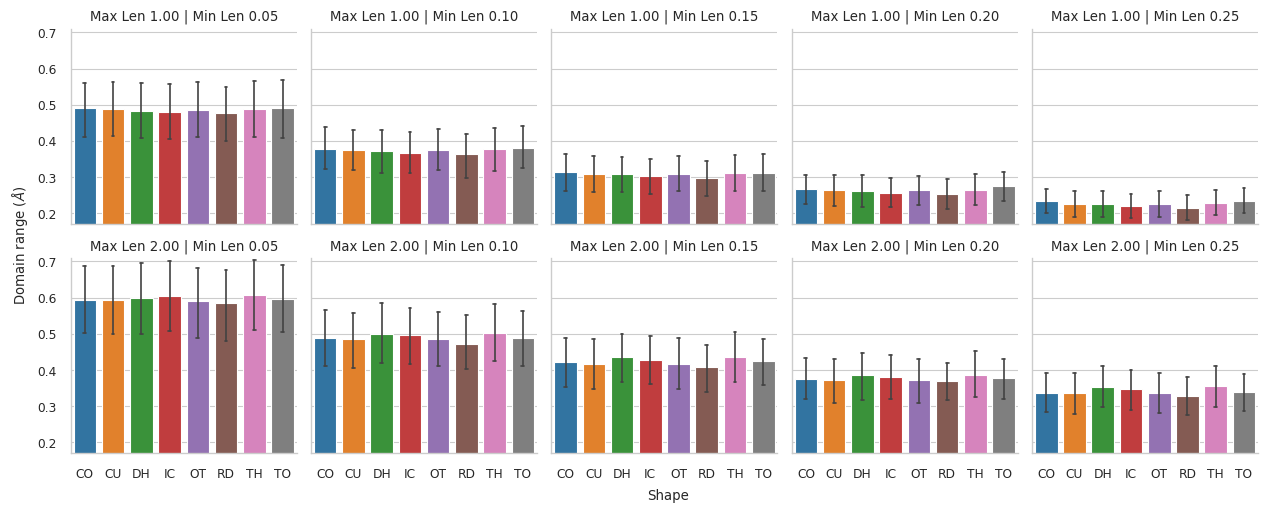

In [269]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    g = sns.FacetGrid(EXDF, col='minLenMult', row='maxLenMult', sharex=True, sharey=True, height=2.5, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='rangeLenEX', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(0.17, 0.71))
    g.set_axis_labels('', r'')
    g.set_titles(row_template='Max Len {row_name:.2f}', col_template='Min Len {col_name:.2f}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.5, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'Domain range ($\AA$)', va='center', rotation='vertical')
    g.tight_layout()
    g.savefig('figures/paramTuneEXBoxLenShapeDomainBarPlot.png')

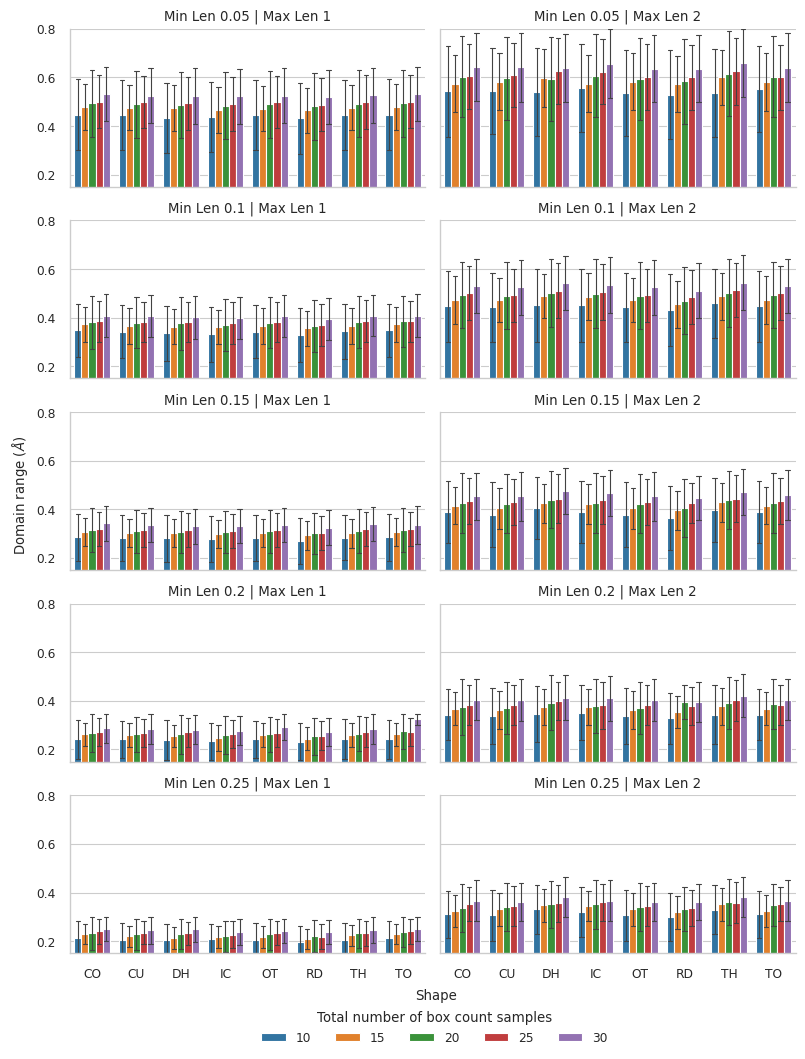

In [284]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    g = sns.FacetGrid(EXDF, row='minLenMult', col='maxLenMult', sharex=True, sharey=True, height=2, aspect=2)
    g.map_dataframe(sns.barplot, x='shape', y='rangeLenEX', hue='numBoxLen', palette='tab10', errwidth=0.8, capsize=0.1)
    g.set(ylim=(0.15, 0.8))
    g.set_axis_labels('', '')
    g.set_titles(col_template='Max Len {col_name}', row_template='Min Len {row_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.34, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'Domain range ($\AA$)', va='center', rotation='vertical')
    g.add_legend(title='Total number of box count samples', loc='lower center', bbox_to_anchor=(0.357, -0.06), ncol=5)
    g.tight_layout()
    g.savefig('figures/paramTuneEXBoxLenShapeNumBoxLenDomainBarPlot.png')

An obvious trend is observed: using smaller minimum box length and larger maximum box length results in wider domain ranges. The impact of nanoparticle shapes on the domain range is negligible. Using larger total number of box count samples also results in wider domain ranges.

#### Box-Counting Dimension Values

Here we look at the impact of the difference in box length ranges and intervals on the values of ${D_B}_E$.

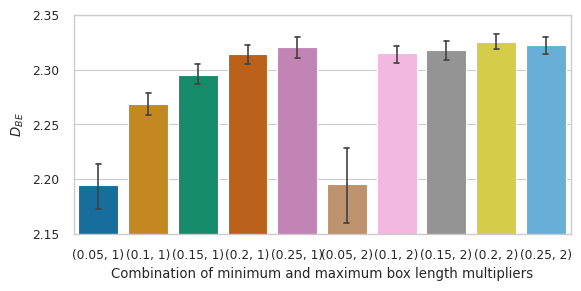

In [294]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=dpi)
sns.barplot(data=EXDF, x='lenMult', y='DBoxEX', errwidth=1.2, capsize=0.1, ax=ax)
plt.ylim(bottom=2.15, top=2.35)
plt.xlabel('Combination of minimum and maximum box length multipliers')
plt.ylabel(r'${D_B}_E$')
plt.tight_layout()
plt.savefig('figures/paramTuneEXBoxLenComboDBoxBarPlot.png')

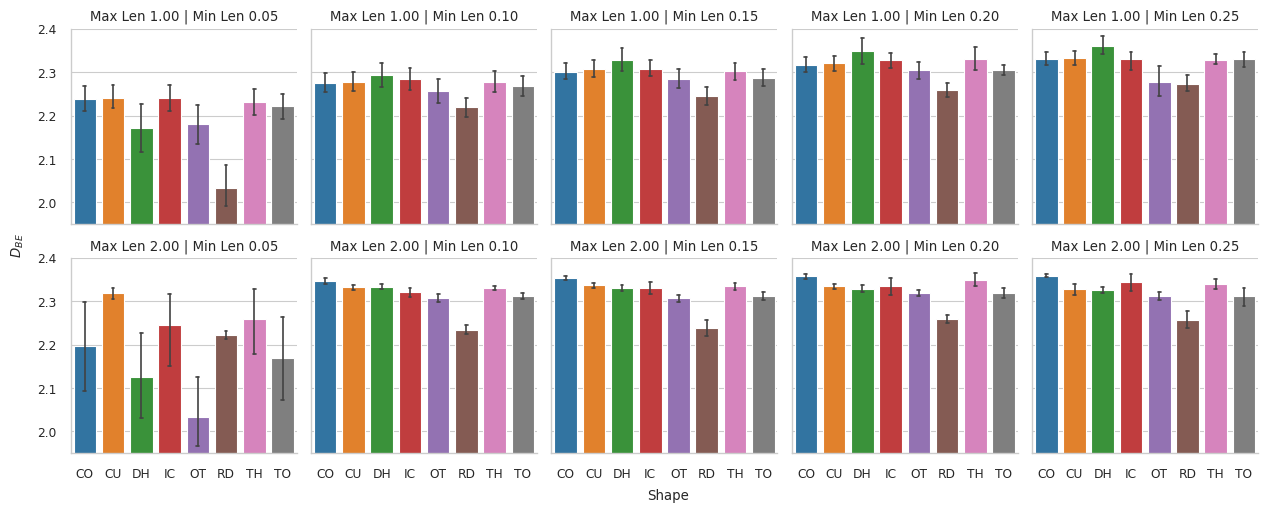

In [293]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    g = sns.FacetGrid(EXDF, col='minLenMult', row='maxLenMult', sharex=True, sharey=True, height=2.5, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='DBoxEX', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(1.95, 2.4))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Max Len {row_name:.2f}', col_template='Min Len {col_name:.2f}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.5, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'${D_B}_E$', va='center', rotation='vertical')
    g.tight_layout()
    g.savefig('figures/paramTuneEXBoxLenShapeDBoxBarPlot.png')

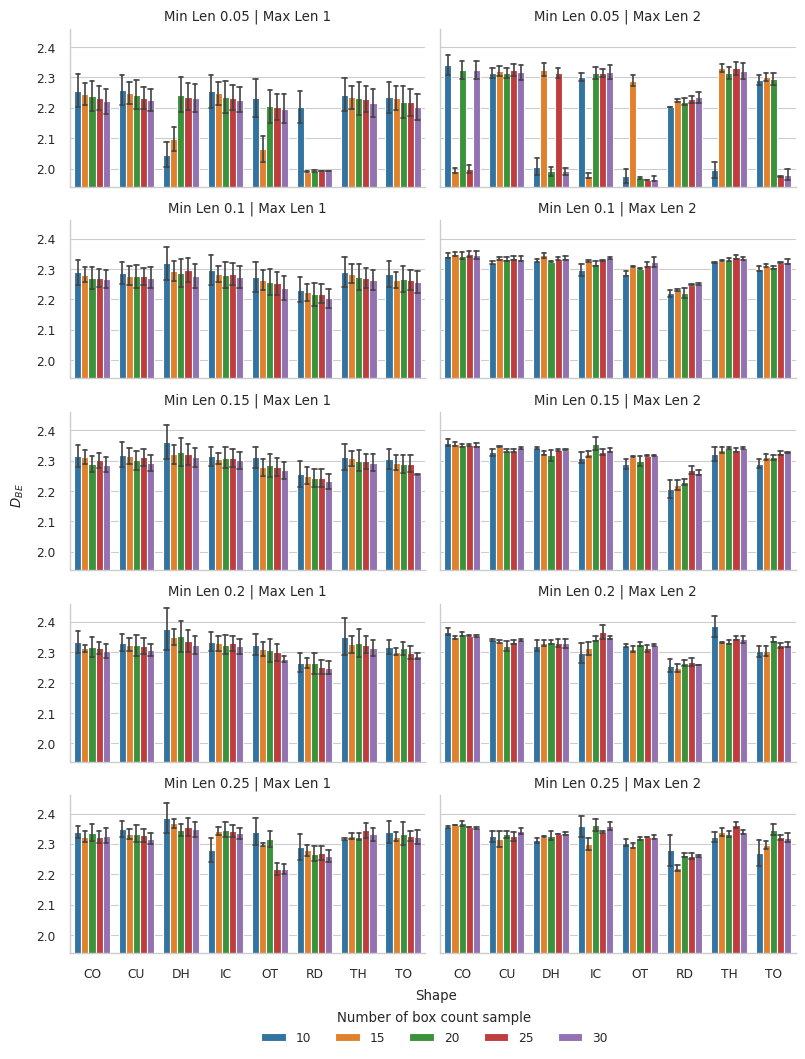

In [297]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    g = sns.FacetGrid(EXDF, row='minLenMult', col='maxLenMult', sharex=True, sharey=True, height=2, aspect=2)
    g.map_dataframe(sns.barplot, x='shape', y='DBoxEX', hue='numBoxLen', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(1.94, 2.46))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Min Len {row_name}', col_template='Max Len {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.34, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'${D_B}_E$', va='center', rotation='vertical')
    g.add_legend(title='Total number of box count samples', loc='lower center', bbox_to_anchor=(0.357, -0.06), ncol=5)
    g.tight_layout()
    g.savefig('figures/paramTuneEXBoxLenShapeNumBoxLenDBoxBarPlot.png')

A general trend is observed: using larger minimum and maximum box length multipliers tend to result in higher ${D_B}_E$.

Using minimum box length multiplier of 0.05 results in ${D_B}_E$ of less than 2.0, which is out of the range of expectation [2, 3] for atomistic surfaces. For other minimum box length multipliers, given the same maximum box length multiplier, the trend in ${D_B}_E$ values across nanoparticles with different shapes largely remains the same. A slight difference in the trend is observed between different maximum box length multipliers.

While the combination that uses the largest initial box length range (0.05, 2.00) returns the highest variance in ${D_B}_E$ values, using larger maximum box length multiplier (2.00) tends to return lower variance of ${D_B}_E$ values.

One of the main aims of computing ${D_B}_E$ is to differentiate between different types of surface packings. The nanoparticles totally encapsulated by the distinct facets {100} (`CU`), {110} (`RD`), and {111} (`OT`) are expected to have very different ${D_B}_E$ values. A general trend is observed: `CU` > `OT` > `RD`. 

#### Conclusion

The combinations of minimum and maximum box length multipliers that allow satisfactory separation between the 3 types of facets (minimal overlapping) are (0.10, 2.00), (0.15, 2.00), and (0.20, 2.00). Taking the total number of box count samples into account, >=25 box count samples are required for the (0.20, 2.00) combination to allow satisfactory capability to distinguish between `CU` and `OT`.

Taking computational expenses and uncertainty in results into account, the values chosen for `numBoxLen`, `minSample`, `minLenMult`, and `maxLenMult` are 10, 5, 0.15, and 2.00, respectively.